<a href="https://colab.research.google.com/github/Armandkay/air-quality-forecasting/blob/main/assignment1_timeseries_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 — Time Series Forecasting (September 2025)

**Student:** Armand Kayiranga   
**Brief:** Use historical air quality and weather data to predict PM2.5 for the provided test timestamps. We use tree-based models (Random Forest and XGBoost) in this notebook.

---

In [ ]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# XGBoost (if not installed, install with pip before running)
try:
    import xgboost as xgb
    xgboost_available = True
except Exception:
    print("xgboost not available — install it with `pip install xgboost` if you want to run XGBoost cells.")
    xgboost_available = False

# Display options
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 140)

RANDOM_STATE = 42

# small helper for RMSE printing
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
from google.colab import files
import os
import pandas as pd

# --- Step 1: List of required files ---
needed_files = ['train.csv', 'test.csv', 'sample_submission.csv']

# --- Step 2: Upload missing files ---
for f in needed_files:
    if f not in os.listdir('/content/'):
        print(f"Please upload {f} (or the file with a similar name):")
        uploaded = files.upload()  # Opens file picker
        break  # Only upload once per missing file

# --- Step 3: Rename sample_submission if it has an extra space ---
for file in os.listdir('/content/'):
    if 'sample_submission' in file and '.csv' in file and file != 'sample_submission.csv':
        os.rename(file, 'sample_submission.csv')
        print(f"Renamed '{file}' to 'sample_submission.csv'")

# --- Step 4: Read CSVs ---
train = pd.read_csv('train.csv', parse_dates=['datetime'])
test = pd.read_csv('test.csv', parse_dates=['datetime'])
sample_sub = pd.read_csv('sample_submission.csv')

# --- Step 5: Quick check ---
print('Train shape:', train.shape)
print('Test shape :', test.shape)
print('Sample submission shape:', sample_sub.shape)
train.head()


Please upload sample_submission.csv (or the file with a similar name):


Saving sample_submission .csv to sample_submission .csv
Renamed 'sample_submission .csv' to 'sample_submission.csv'
Train shape: (30676, 12)
Test shape : (13148, 11)
Sample submission shape: (13148, 2)


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [ ]:
# Update paths below if your files are in a different place
train_path = 'train.csv'
test_path = 'test.csv'
sample_sub_path = '/content/sample_submission.csv'

train = pd.read_csv(train_path, parse_dates=['datetime'])
test = pd.read_csv(test_path, parse_dates=['datetime'])
sample_sub = pd.read_csv(sample_sub_path)

print('Train shape:', train.shape)
print('Test shape :', test.shape)
train.head()

Train shape: (30676, 12)
Test shape : (13148, 11)


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> I checked the shapes and previewed the first rows to make sure the data loaded correctly.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   No        30676 non-null  int64         
 1   DEWP      30676 non-null  float64       
 2   TEMP      30676 non-null  float64       
 3   PRES      30676 non-null  float64       
 4   Iws       30676 non-null  float64       
 5   Is        30676 non-null  float64       
 6   Ir        30676 non-null  float64       
 7   datetime  30676 non-null  datetime64[ns]
 8   cbwd_NW   30676 non-null  float64       
 9   cbwd_SE   30676 non-null  float64       
 10  cbwd_cv   30676 non-null  float64       
 11  pm2.5     28755 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 2.8 MB
None

Missing values (train):
No             0
DEWP           0
TEMP           0
PRES           0
Iws            0
Is             0
Ir             0
datetime       0
cbwd_NW    

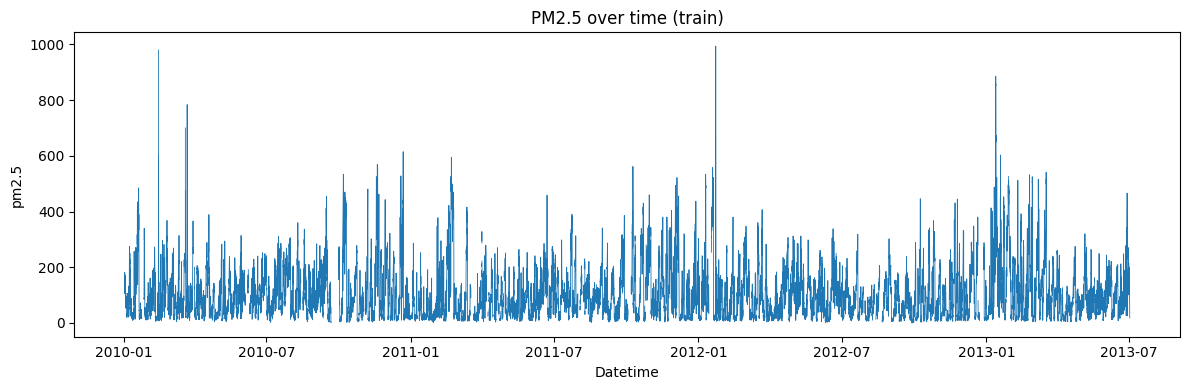

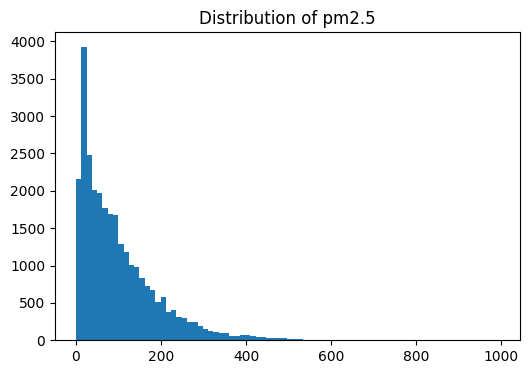

In [ ]:
# Basic info and missing values
print(train.info())
print('\nMissing values (train):')
print(train.isnull().sum())

# Basic statistics for the target
print('\npm2.5 stats:')
print(train['pm2.5'].describe())

# Plot a quick line plot for pm2.5
plt.figure(figsize=(12,4))
plt.plot(train['datetime'], train['pm2.5'], lw=0.6)
plt.title('PM2.5 over time (train)')
plt.xlabel('Datetime')
plt.ylabel('pm2.5')
plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(6,4))
plt.hist(train['pm2.5'].dropna(), bins=80)
plt.title('Distribution of pm2.5')
plt.show()

> PM2.5 shows spikes and long tails. Some features have missing values; I'll fill those conservatively to avoid biasing the model.

In [ ]:
def create_lag_features(df, lags=[1,2,3,6,12,24]):
    df = df.copy()
    for lag in lags:
        df[f'pm2.5_lag_{lag}'] = df['pm2.5'].shift(lag)
    return df

# Work on combined frame so transformation is consistent
train_sorted = train.sort_values('datetime').reset_index(drop=True)
train_lagged = create_lag_features(train_sorted)

# extract basic datetime features
for df in [train_lagged]:
    df['hour'] = df['datetime'].dt.hour
    df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['weekday'] = df['datetime'].dt.weekday

# For test, we need datetime features; lags will be seeded from train later
test_sorted = test.sort_values('datetime').reset_index(drop=True)
for df in [test_sorted]:
    df['hour'] = df['datetime'].dt.hour
    df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['weekday'] = df['datetime'].dt.weekday

train_lagged.head(6)

,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5,pm2.5_lag_1,pm2.5_lag_2,pm2.5_lag_3,pm2.5_lag_6,pm2.5_lag_12,pm2.5_lag_24,hour,day,month,weekday
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,4
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,4
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,1,4
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,1,4
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,1,4
5,6,-1.442309,-1.840273,0.053790,-0.155751,-0.069353,-0.137667,2010-01-01 05:00:00,1.448138,-0.732019,-0.522096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1,4


> I made lag features at a few useful intervals (1,2,3,6,12,24 hours). This helps the model see recent trends without LSTM.

In [ ]:
# Fill missing numeric features with median (simple and safe)
numeric_cols = train_lagged.select_dtypes(include=[np.number]).columns.tolist()

# Fill medians (lags will have NaNs at the top)
train_lagged[numeric_cols] = train_lagged[numeric_cols].fillna(train_lagged[numeric_cols].median())

# Label encode cbwd if exists
if 'cbwd' in train_lagged.columns:
    le = LabelEncoder()
    combined_cbwd = pd.concat([train_lagged['cbwd'], test_sorted.get('cbwd', pd.Series(dtype='object'))])
    le.fit(combined_cbwd.fillna('NA'))
    train_lagged['cbwd_enc'] = le.transform(train_lagged['cbwd'].fillna('NA'))
    test_sorted['cbwd_enc'] = le.transform(test_sorted['cbwd'].fillna('NA'))

# Quick check
train_lagged.isnull().sum().sort_values(ascending=False).head(10)

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
datetime,0
cbwd_NW,0
cbwd_SE,0


> I used median for numeric missing data to keep things robust to outliers.

In [ ]:
# Drop rows where target pm2.5 is null (if any)
train_final = train_lagged.dropna(subset=['pm2.5']).reset_index(drop=True)

# Choose features: lags + weather + datetime encodings
feat_cols = []
for col in train_final.columns:
    if col.startswith('pm2.5_lag_'):
        feat_cols.append(col)

for c in ['DEWP','TEMP','PRES','Iws','Is','Ir','cbwd_enc','hour','day','month','weekday']:
    if c in train_final.columns:
        feat_cols.append(c)

print('Features used:', feat_cols)

X = train_final[feat_cols]
y = train_final['pm2.5']

# time-based split: last 20% -> validation
split_idx = int(len(X) * 0.8)
X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]

print('Train rows:', X_train.shape[0], 'Val rows:', X_val.shape[0])

Features used: ['pm2.5_lag_1', 'pm2.5_lag_2', 'pm2.5_lag_3', 'pm2.5_lag_6', 'pm2.5_lag_12', 'pm2.5_lag_24', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'hour', 'day', 'month', 'weekday']
Train rows: 24540 Val rows: 6136


> I split by time so validation simulates future data.

In [ ]:
rf = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)

val_pred_rf = rf.predict(X_val)
print('RF validation RMSE:', rmse(y_val, val_pred_rf))

# feature importances quick check
imp = pd.Series(rf.feature_importances_, index=feat_cols).sort_values(ascending=False)
print(imp.head(12))

RF validation RMSE: 32.326263466674334
pm2.5_lag_1     0.944936
pm2.5_lag_2     0.012948
DEWP            0.007466
pm2.5_lag_3     0.006305
pm2.5_lag_12    0.003933
Iws             0.003909
pm2.5_lag_6     0.003832
pm2.5_lag_24    0.003095
PRES            0.002940
hour            0.002601
TEMP            0.002323
day             0.002076
dtype: float64


> Random Forest gives a robust baseline and helps identify which lag/features matter most.

In [ ]:
if xgboost_available:
    import xgboost as xgb

    # Convert data to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.05,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': RANDOM_STATE
    }

    evals = [(dtrain, 'train'), (dval, 'val')]

    xg_model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=500,
        evals=evals,
        early_stopping_rounds=25,
        verbose_eval=False
    )

    # Predictions on validation set
    val_pred_xgb = xg_model.predict(dval)
    print('XGB validation RMSE:', rmse(y_val, val_pred_xgb))
else:
    print('XGBoost not installed; skip XGB stage or install xgboost.')

XGB validation RMSE: 31.34532899256929


> I used early stopping to avoid overfitting and speed up training.

In [ ]:
# helper to build initial test frame with lag columns
def prepare_test_with_lags(train_df, test_df, lags=[1,2,3,6,12,24]):
    seed = train_df[['datetime','pm2.5']].copy().sort_values('datetime')
    seed = seed.tail(max(lags))

    test_df = test_df.copy()
    for lag in lags:
        test_df[f'pm2.5_lag_{lag}'] = np.nan

    # Fill initial lags for first rows of test from seed
    for i in range(len(test_df)):
        for lag in lags:
            ref_idx = i - lag
            if ref_idx >= 0:
                pass
            else:
                seed_idx = ref_idx + len(seed)
                if 0 <= seed_idx < len(seed):
                    test_df.at[i, f'pm2.5_lag_{lag}'] = seed.iloc[seed_idx]['pm2.5']
                else:
                    test_df.at[i, f'pm2.5_lag_{lag}'] = np.nan

    # datetime features
    test_df['hour'] = test_df['datetime'].dt.hour
    test_df['day'] = test_df['datetime'].dt.day
    test_df['month'] = test_df['datetime'].dt.month
    test_df['weekday'] = test_df['datetime'].dt.weekday

    # encode cbwd if present
    if 'cbwd' in test_df.columns and 'cbwd_enc' in train_lagged.columns:
        try:
            test_df['cbwd_enc'] = le.transform(test_df['cbwd'].fillna('NA'))
        except Exception:
            test_df['cbwd_enc'] = 0

    return test_df

lags = [1,2,3,6,12,24]
test_prepped = prepare_test_with_lags(train_sorted, test_sorted, lags=lags)
features_for_test = [c for c in feat_cols if c in test_prepped.columns]

# sequential prediction using chosen model (RF or XGB)
model_to_use = rf

preds = []
# Work on a copy we can update with predicted pm2.5 values
test_work = test_prepped.copy()

for i in range(len(test_work)):
    row = test_work.iloc[i:i+1].copy()
    X_row = row[features_for_test].fillna(train_final[features_for_test].median()).values
    p = model_to_use.predict(X_row)[0]
    preds.append(p)
    for lag in lags:
        future_idx = i + lag
        if future_idx < len(test_work):
            test_work.at[test_work.index[future_idx], f'pm2.5_lag_{lag}'] = p

print('Generated', len(preds), 'test predictions')

# Put into submission
submission = sample_sub.copy()
if 'pm2.5' in submission.columns:
    submission['pm2.5'] = preds
elif 'value' in submission.columns:
    submission['value'] = preds
else:
    submission = pd.DataFrame({'datetime': test['datetime'], 'pm2.5': preds})

submission.to_csv('submission.csv', index=False)
print('Saved submission.csv — ready to upload to Kaggle')

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted 

Generated 13148 test predictions
Saved submission.csv — ready to upload to Kaggle


> The sequential filling approach is a simple forecasting method that uses previous predictions as lags. It's not perfect but works well with tree models in contests like this.